# Colab에서 구글드라이브 연결하기

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 필요한 모듈 import 하기
 

In [2]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 판다스를 이용하여 파일 불러오기
 

In [3]:
# sep(seperate) : tap으로 나누어서 있다, 구분 되어져있다.
# names : column명을 직접 알려준다

train = pd.read_csv("/content/gdrive/MyDrive/ColabNotebooks/ua.base",
                   sep="\t", names=['user', 'movie', 'rating', 'timestamp'])


test = pd.read_csv("/content/gdrive/MyDrive/ColabNotebooks/ua.test",
                  sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

In [4]:
# 10만개의 데이터 확인
print(train)
print(test)

       user  movie  rating  timestamp
0         1      1       5  874965758
1         1      2       3  876893171
2         1      3       4  878542960
3         1      4       3  876893119
4         1      5       3  889751712
...     ...    ...     ...        ...
90565   943   1047       2  875502146
90566   943   1074       4  888640250
90567   943   1188       3  888640250
90568   943   1228       3  888640275
90569   943   1330       3  888692465

[90570 rows x 4 columns]
      user  movie  rating  timestamp
0        1     20       4  887431883
1        1     33       4  878542699
2        1     61       4  878542420
3        1    117       3  874965739
4        1    155       2  878542201
...    ...    ...     ...        ...
9425   943    232       4  888639867
9426   943    356       4  888639598
9427   943    570       1  888640125
9428   943    808       4  888639868
9429   943   1067       2  875501756

[9430 rows x 4 columns]


# pytorch tensor 데이터로 변환
 

In [5]:
# train data
items = torch.tensor(train['movie'], dtype=torch.long)
users = torch.tensor(train['user'], dtype=torch.long)
ratings = torch.tensor(train['rating'], dtype=torch.float)

# test data
items_test = torch.tensor(test['movie'], dtype=torch.long)
users_test = torch.tensor(test['user'], dtype=torch.long)
ratings_test = torch.tensor(test['rating'], dtype=torch.float)

In [6]:
# rank → 사용자 vector, 아이템 vector의 차원
# numUsers → 사용자 수
# numItems → 아이템 수
# P → 아이템매트릭스
# Q → 사용자매트릭스
 
rank = 10 # rank를 10으로 설정 (차원)
numItems = items.max() + 1 # max값에 1더하면 원하는 수 찾을 수 있다.
numUsers = users.max() + 1

# P, Q 매트릭스 -> 학습해야하는 데이터라 requires_grad를 True로
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

In [7]:
print(P.shape)
print(Q.shape)

torch.Size([1683, 10])
torch.Size([944, 10])


In [8]:
# 10번 user가 20번 영화에 몇 점을 주었을지 예측하자면 ?
(P[20] * Q[10]).sum()

tensor(2.1564, grad_fn=<SumBackward0>)

# Latent Factor Model



In [9]:
# 기본 Matrix Factorization 구현
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

optim = torch.optim.Adam([P, Q], lr= 0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):

  h = torch.sum(P[items] * Q[users], dim=1) # h = (P[items] * Q[users]).sum(dim=1) 
  cost = F.mse_loss(h, ratings)

  optim.zero_grad()
  cost.backward()
  optim.step()


  with torch.no_grad():

    X.append(epoch)
    Y.append(cost.item())

    h_test = (P[items_test] * Q[users_test]).sum(dim=1)
    cost_test = F.mse_loss(h_test, ratings_test)

    Y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))

epoch: 0, cost: 23.425909
epoch: 100, cost: 0.561678
epoch: 200, cost: 0.493469
epoch: 300, cost: 0.470130
epoch: 400, cost: 0.459615
epoch: 500, cost: 0.454312
epoch: 600, cost: 0.451093
epoch: 700, cost: 0.448735
epoch: 800, cost: 0.446802
epoch: 900, cost: 0.445260
epoch: 1000, cost: 0.444076


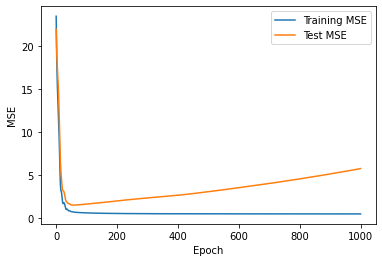

In [10]:
# Matplotlib으로 epoch 마다 Training MSE 그려보기

plt.ylabel("MSE")
plt.xlabel("Epoch")

plt.plot(X, Y, label="Training MSE")
plt.plot(X, Y_test, label="Test MSE")

plt.legend()
plt.show()

epoch: 0, cost: 23.64555549621582, test_cost: 22.23738670349121
epoch: 100, cost: 0.6660714149475098, test_cost: 1.023863434791565
epoch: 200, cost: 0.6049926280975342, test_cost: 1.0226562023162842
epoch: 300, cost: 0.5931204557418823, test_cost: 1.0205250978469849
epoch: 400, cost: 0.5897976160049438, test_cost: 1.0180668830871582
epoch: 500, cost: 0.5886696577072144, test_cost: 1.0179351568222046
epoch: 600, cost: 0.5880562663078308, test_cost: 1.0192270278930664
epoch: 700, cost: 0.5877630710601807, test_cost: 1.0197339057922363
epoch: 800, cost: 0.5876034498214722, test_cost: 1.019455075263977
epoch: 900, cost: 0.5874850153923035, test_cost: 1.0188363790512085
epoch: 1000, cost: 0.5873963832855225, test_cost: 1.01813805103302


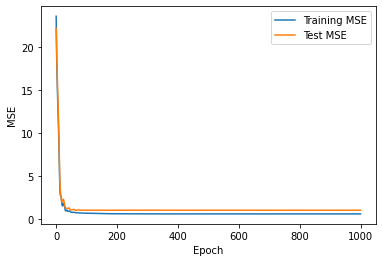

In [13]:
# Regularization 추가하기

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

lambda1 = 1
lambda2 = 1

optim = torch.optim.Adam([P, Q], lr= 0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):

  h = torch.sum(P[items] * Q[users], dim=1) # h = (P[items] * Q[users]).sum(dim=1) 
  cost = F.mse_loss(h, ratings) 
  # Regularization term 덕분에 오버피팅을 막았다.
  loss = cost + lambda1 * (P*P).mean() + lambda2 * (Q*Q).mean()
  # 왜 sum 이 아니라 mean을 했냐 
  # 각각의 값에 제곱을 한 다음에 평균을 한 값이 낮아지게끔 학습을 하면 튀는 현상을 막을 수 있는데
  # 각각의 값을 제곱을 한 뒤에 sum 한 값을 낮게 해도 튀는 애들이 사라진다. 
  # 대신 람다값이 sum 할 때는 좀 더 작아져야 겠죠 ? 고 정도 차이

  optim.zero_grad()
  loss.backward()
  optim.step()


  with torch.no_grad():

    X.append(epoch)
    Y.append(cost.item())

    h_test = (P[items_test] * Q[users_test]).sum(dim=1)
    cost_test = F.mse_loss(h_test, ratings_test)

    Y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}, test_cost: {cost_test.item()}")



plt.ylabel("MSE")
plt.xlabel("Epoch")

plt.plot(X, Y, label="Training MSE")
plt.plot(X, Y_test, label="Test MSE")

plt.legend()
plt.show()

# Bias 추가하기

In [15]:
# global baseline estimate에서 너무 데이터가 sparse할 때에는 평균값을 알려주는게 더 좋을 수 있다
# 그 개념을 Latent Factor Model에 잘 녹여내면 좋지 않을까 ?

# 각 유저와 매트릭스마다 기본값을 할당을 해주고 기본값보다 예측값이 얼마나 벗어나 있는지를 
# P, Q 매트릭스로 학습해서 넣어주면은 더 정확도가 올라갈 것이다 


P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

bias_item = torch.randn(numItems, requires_grad=True) # numItems만큼의 차원
bias_user = torch.randn(numUsers, requires_grad=True) # numUsers만큼의 차원
mean = ratings.mean()

lambda3 = 1
lambda4 = 1

optim = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):

  # 각각의 아이템벡터 유저벡터를 내적한 것에 평균, 아이템의 바이어스, 유저의 바이어스를 더해준 것을 가설함수로 만들자
  h = (P[items] * Q[users]).sum(dim=1) + mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(h, ratings)
  loss = cost + lambda1 * (P*P).mean() + lambda2 * (Q*Q).mean() + \
          lambda3 * (bias_user**2).mean() +lambda4*(bias_item**2).mean()


  optim.zero_grad()
  loss.backward()
  optim.step()


  with torch.no_grad():

    X.append(epoch)
    Y.append(cost.item())

    h_test = (P[items_test] * Q[users_test]).sum(dim=1) + \
              mean + bias_item[items_test] + bias_user[users_test]

    cost_test = F.mse_loss(h_test, ratings_test)

    Y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}, test_cost: {cost_test.item()}")


epoch: 0, cost: 13.541299819946289, test_cost: 10.43134593963623
epoch: 100, cost: 0.6062437891960144, test_cost: 0.9257848858833313
epoch: 200, cost: 0.5782127976417542, test_cost: 0.9153028130531311
epoch: 300, cost: 0.5738480091094971, test_cost: 0.9125317931175232
epoch: 400, cost: 0.572788417339325, test_cost: 0.9116465449333191
epoch: 500, cost: 0.5721743106842041, test_cost: 0.9114572405815125
epoch: 600, cost: 0.5718441605567932, test_cost: 0.9109041690826416
epoch: 700, cost: 0.571670413017273, test_cost: 0.9101395606994629
epoch: 800, cost: 0.5714727640151978, test_cost: 0.9089874029159546
epoch: 900, cost: 0.5711406469345093, test_cost: 0.908250629901886
epoch: 1000, cost: 0.5709450244903564, test_cost: 0.908043622970581


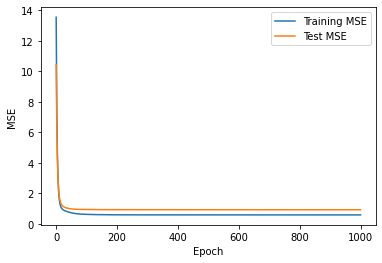

In [16]:
plt.ylabel("MSE")
plt.xlabel("Epoch")

plt.plot(X, Y, label="Training MSE")
plt.plot(X, Y_test, label="Test MSE")

plt.legend()
plt.show()